***
# Setup

In [1]:
import sys,os
sys.path.append(os.path.expanduser('~/dtreeviz'))

import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification

from dtreeviz import trees
from dtreeviz.models.sklearn_decision_trees import ShadowSKDTree
from dtreeviz.colors import mpl_colors

from wand.image import Image
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

rnd_seed = 42
np.random.seed(rnd_seed)

In [2]:
inline=True # plot inline or to pdf
output = './output_dtreeviz_demo' # output dir
os.makedirs(output, exist_ok=True)

In [3]:
def save_dtreeviz(viz, m_path, fname, tag='', inline=inline, svg=False, png=False, pdf=True):
    if inline:
        display(viz)
    else:
        if not (svg or png or pdf):
            warnings.warn('Not saving anything!')

        os.makedirs(m_path, exist_ok=True)
        full_path = f'{m_path}/{fname}{tag}'

        # svg
        viz.save(f'{full_path}.svg')

        # pdf via svglib
        if pdf:
            renderPDF.drawToFile(svg2rlg(f'{full_path}.svg'), f'{full_path}.pdf')

        # png via wand / ImageMagick
        if png:
            img = Image(filename=f'{full_path}.svg', resolution=500)
            img.format = 'png'
            img.save(filename=f'{full_path}.png')

        if not svg:
            # clean up svg
            os.remove(f'{full_path}.svg')

        # clean up graphviz dot file (no extension)
        os.remove(full_path)

In [4]:
def save_plt(m_path, fname, tag='', inline=inline):
    plt.tight_layout()
    if inline:
        plt.show()
    else:
        os.makedirs(m_path, exist_ok=True)
        plt.savefig(f'{m_path}/{fname}{tag}.pdf')
        plt.close('all')

***
# Generate Random Data

In [5]:
X, y = make_classification(n_samples=int(1e5),
    n_classes=2,
    shuffle=False,
    shift=0.0,
    scale=1.0,
    hypercube=True,
    n_features=15,
    n_informative=5,
    n_redundant=2,
    n_repeated=0, 
    n_clusters_per_class=5,
    weights=[0.5],
    flip_y=0.05,
    class_sep=0.9, 
    random_state=rnd_seed,
)

feat_names = [f'x_{_}' for _ in range(X.shape[1])]

***
# Train Model

In [6]:
model = DecisionTreeClassifier(max_depth=3, random_state=rnd_seed+1)
model.fit(X, y);
model.feature_names = feat_names

***
# `dtreeviz` Plots

In [7]:
color_params = {'classes': mpl_colors, 'hist_bar': 'C0', 'legend_edge': None}
for _ in ['axis_label', 'title', 'legend_title', 'text', 'arrow', 'node_label', 'tick_label', 'leaf_label', 'wedge', 'text_wedge']:
    color_params[_] = 'black'
dtv_params_gen = {'colors': color_params, 'fontname': 'Arial'}
dtv_params = {'leaf_plot_type': 'barh',
              'all_axes_spines': False,
              'label_fontsize': 10,
              'colors': dtv_params_gen['colors'],
              'fontname': dtv_params_gen['fontname']
             }

In [8]:
shadow_tree = ShadowSKDTree(model, X, y, feat_names, 'y', [0, 1])

In [9]:
x_example = X[13]
feature_to_look_at_in_detail = 'x_1'
display(pd.DataFrame([{col: value for col,value in zip(feat_names, x_example)}]))

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,x_12,x_13,x_14
0,2.42538,1.267974,2.303804,-0.636874,-0.121393,-0.205423,-0.502339,0.643387,-0.643301,-2.299074,-0.147235,1.227843,0.708903,-0.043485,0.926461


### Trees

#### Split Hists

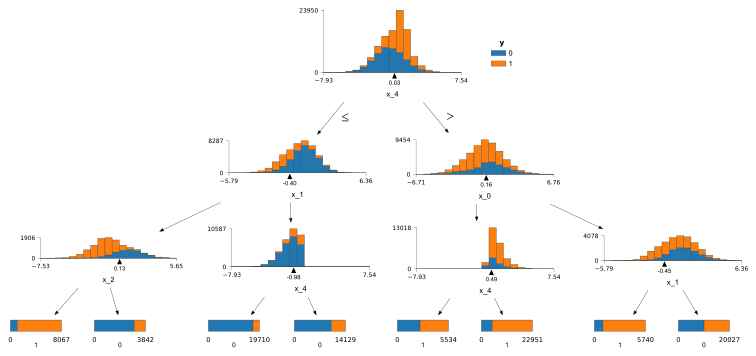

In [10]:
viz = trees.dtreeviz(shadow_tree, **dtv_params)
save_dtreeviz(viz, output, 'dtreeviz')

#### Text

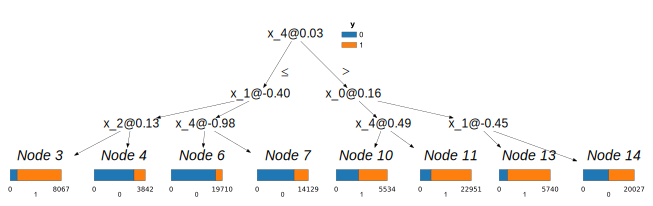

In [11]:
viz = trees.dtreeviz(shadow_tree, **dtv_params, fancy=False, show_node_labels=True)
save_dtreeviz(viz, output, 'dtreeviz_text')

### Prediction Path

In [12]:
print(trees.explain_prediction_path(shadow_tree, x=x_example, explanation_type='plain_english'))

-0.4 <= x_1 
-0.98 <= x_4  < 0.03



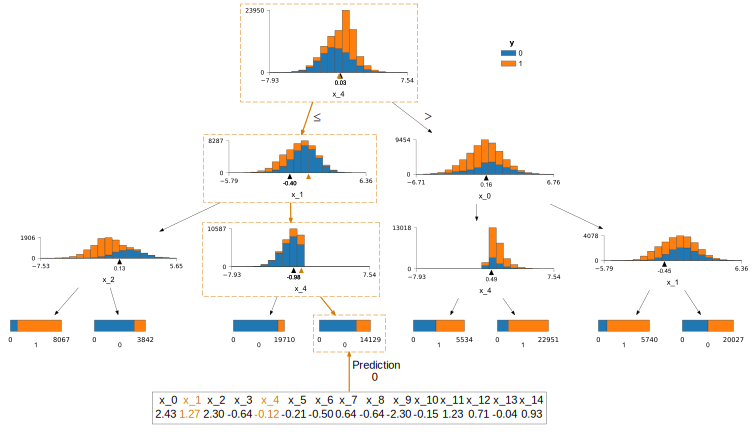

In [13]:
viz = trees.dtreeviz(shadow_tree, **dtv_params, X=x_example)
save_dtreeviz(viz, output, 'dtreeviz_pred_path')

### Leaf Samples

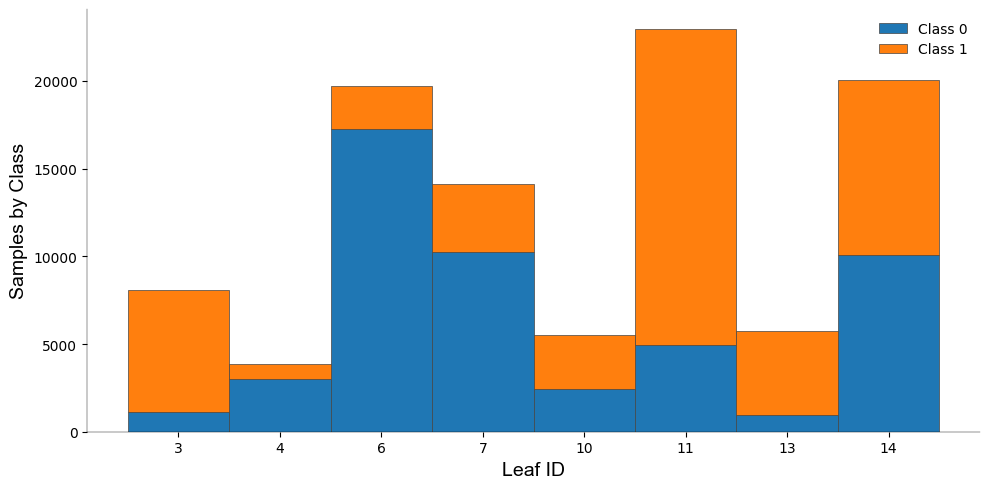

In [14]:
trees.ctreeviz_leaf_samples(shadow_tree, **dtv_params_gen)
save_plt(output, 'ctreeviz_leaf_samples')

### Leaf Criterion

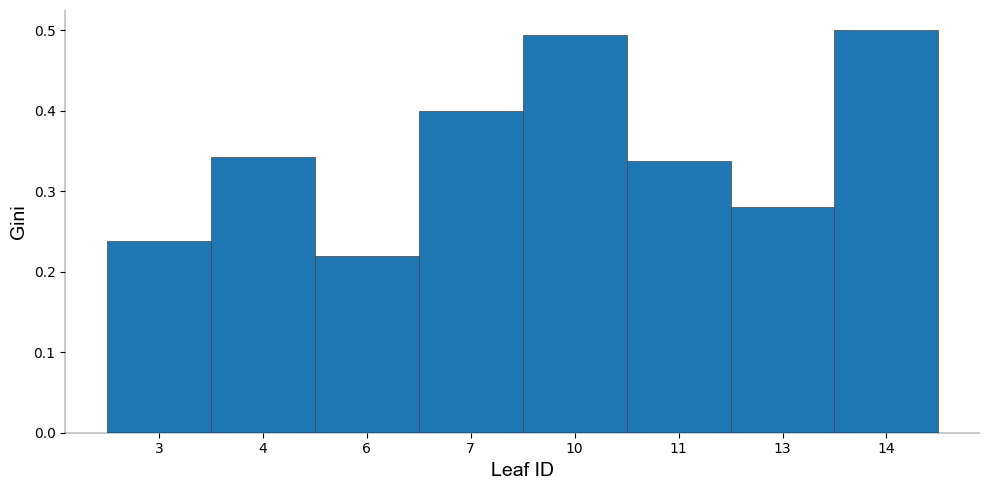

In [15]:
trees.viz_leaf_criterion(shadow_tree, display_type='plot', **dtv_params_gen)
save_plt(output, 'viz_leaf_criterion')

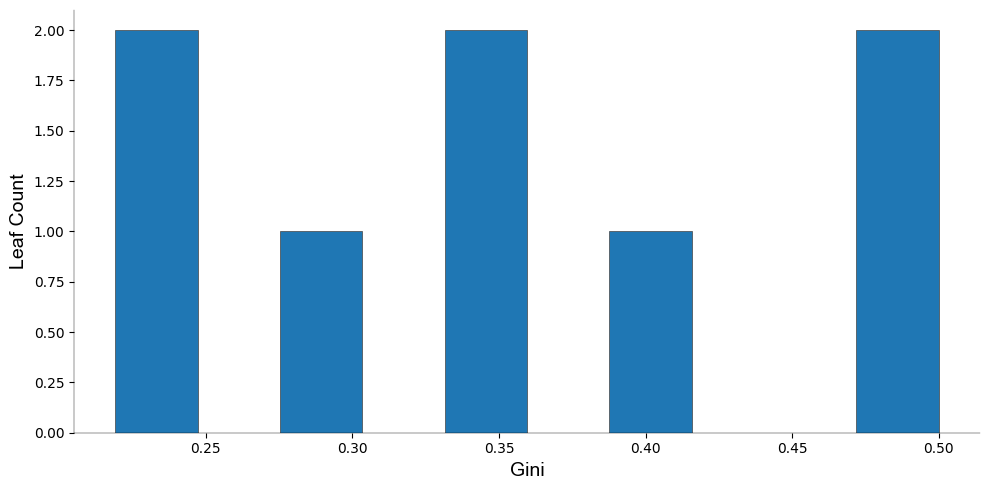

In [16]:
trees.viz_leaf_criterion(shadow_tree, display_type='hist', **dtv_params_gen)
save_plt(output, 'viz_leaf_criterion_hist')

### Splits in Feature Space

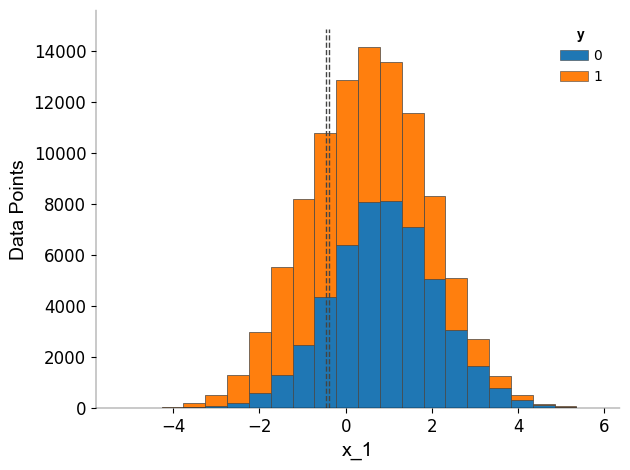

In [17]:
trees.ctreeviz_univar(shadow_tree, feature_name=feature_to_look_at_in_detail, **dtv_params_gen, gtype = 'barstacked', show={'legend', 'splits', 'axis'})
save_plt(output, 'ctreeviz_univar')

### Node Sample

In [18]:
trees.describe_node_sample(shadow_tree, 3)

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,x_12,x_13,x_14
count,8067.000000,8067.000000,8067.000000,8067.000000,8067.000000,8067.000000,8067.000000,8067.000000,8067.000000,8067.000000,8067.000000,8067.000000,8067.000000,8067.000000,8067.000000
mean,-0.653616,-1.341483,-1.584087,-1.091585,-1.335935,-1.878241,1.518202,-0.011420,0.002749,0.012706,-0.024658,0.005400,-0.026443,-0.028694,-0.003251
std,1.323487,0.685798,1.131589,1.078168,0.999084,1.861551,0.927738,1.012433,0.993656,0.999835,1.005479,1.007327,0.983535,0.997382,1.005556
min,-5.876140,-4.670872,-7.534189,-4.770642,-5.895614,-9.372821,-1.295288,-3.865577,-3.759137,-3.492054,-3.728891,-3.792811,-3.377670,-3.494883,-4.075793
25%,-1.505829,-1.717586,-2.247812,-1.850328,-1.939332,-2.999227,0.842825,-0.697833,-0.663218,-0.667413,-0.706706,-0.690361,-0.690180,-0.704436,-0.676498
50%,-0.894709,-1.216393,-1.430502,-1.095902,-1.168094,-1.802833,1.439746,-0.001864,-0.004356,-0.004474,-0.013986,0.005820,-0.035601,-0.023936,0.002433
75%,-0.089180,-0.813328,-0.704657,-0.374338,-0.519884,-0.707711,2.099302,0.679678,0.666339,0.698135,0.653092,0.691417,0.638942,0.632427,0.681958
max,6.091351,-0.395725,0.125367,4.466985,0.029094,6.188380,5.488906,4.315949,3.535015,4.152785,4.193026,3.954381,4.015024,3.309221,3.382322
